In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-12-04 15:18:36.284894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 15:18:36.292921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 15:18:36.301064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 15:18:36.303383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 15:18:36.310829: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1733350719.787200 1904644 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733350719.811414 1904644 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733350719.814234 1904644 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733350719.817631 1904644 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    inputs = np.load("all_inputs_with_height.npy")

In [4]:
inputs.shape

(3467, 512, 512, 2)

In [59]:
len(inputs[0][0].flatten())

1024

In [4]:
batchsize = 32

with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    targets = np.load("all_targets_with_height.npy")
    # train test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(inputs, targets, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

with tf.device("/CPU:0") :
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
with tf.device("/GPU:0") :
    train_dataset = train_dataset.shuffle(buffer_size=200).batch(batchsize)
    val_dataset = val_dataset.shuffle(buffer_size=200).batch(batchsize)

In [6]:
targets.shape

(3467,)

In [5]:
conv_dim = 16
ff_dim = 32
k_dim = 3
pool_dim = 5
drop_rate = 0.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), activation='relu', input_shape=(512, 512, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Conv2D(conv_dim, kernel_size = (k_dim, k_dim), padding ='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(pool_dim,pool_dim),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(ff_dim, activation='relu'),
  tf.keras.layers.Dropout(drop_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 16)   │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 510, 510, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 510, 510, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 102, 102, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 102, 102, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,809 (38.32 KB)

 Trainable params: 9,713 (37.94 KB)

 Non-trainable params: 96 (384.00 B)

In [6]:
#model.compile(optimizer=Adam(learning_rate=1e-4),
#model.compile(optimizer=Adam(learning_rate=1e-2),
#model.compile(optimizer=Adam(learning_rate=1e-5),
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [7]:
model_checkpoint = ModelCheckpoint(
  filepath='checkpoint.model_low_lr.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)

optim = model.fit(train_dataset,
                  validation_data=val_dataset, 
                  epochs=100, 
                  callbacks=[model_checkpoint])

Epoch 1/100


I0000 00:00:1733350746.493670 1904787 service.cc:146] XLA service 0x710808011880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733350746.493692 1904787 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-12-04 15:19:06.516995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 15:19:06.641393: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 5/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5017 - loss: 1.3053

I0000 00:00:1733350749.000088 1904787 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.4580 - loss: 1.3444 - val_accuracy: 0.5315 - val_loss: 0.7140
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4562 - loss: 1.0636 - val_accuracy: 0.5315 - val_loss: 0.7738
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4519 - loss: 0.8951 - val_accuracy: 0.5315 - val_loss: 0.8357
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4549 - loss: 0.8171 - val_accuracy: 0.5315 - val_loss: 0.8916
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4898 - loss: 0.7754 - val_accuracy: 0.5315 - val_loss: 0.9172
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5088 - loss: 0.7580 - val_accuracy: 0.5315 - val_loss: 0.9210
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5143 - loss: 0.7509 - val_accuracy: 0.5315 - val_loss: 0.9074
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5191 - loss: 0.7444 - val_accuracy: 0.5315 - val_

In [10]:
optim.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
train_acc_arr = np.array(optim.history['accuracy'])
val_acc_arr = optim.history['val_accuracy']
val_loss_arr = optim.history['val_loss']

In [31]:
epochs = []
for i in range(100):
    if train_acc_arr[i] > 0.98:
        epochs.append(i)

first_epoch_exceed_98 = epochs[0]
first_epoch_exceed_98

32

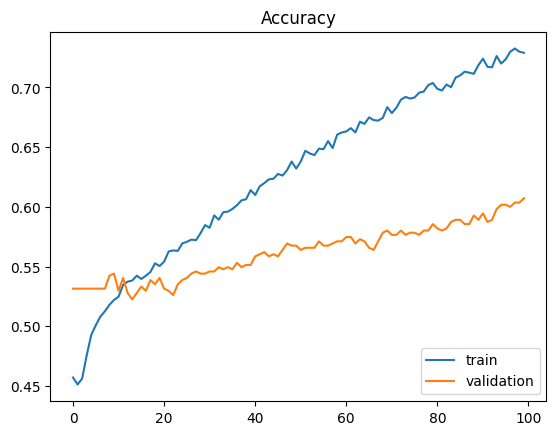

In [8]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.show()

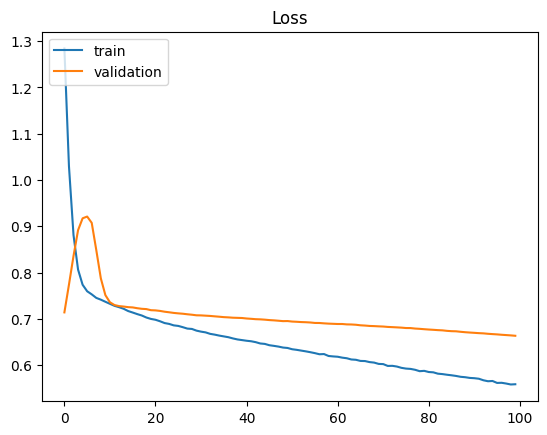

: 

In [9]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Loss')
plt.show()

In [34]:
def calculate_quarter_stats(val_loss, val_acc):
    x = np.arange(25)
    val_acc_diff = np.gradient(val_acc)
    val_loss_diff = np.gradient(val_loss)
    slope, _ = np.polyfit(x, val_loss, 1)
    return {
        "min_loss": np.min(val_loss),
        "max_loss": np.max(val_loss),
        "min_acc": np.min(val_acc),
        "max_acc": np.max(val_acc),
        "std_loss" : np.std(val_loss),
        "r_loss": np.corrcoef(x, val_loss)[0, 1],
        "slope_loss": slope,
        "avg_loss_gradient": np.mean(val_loss_diff),
        "avg_acc_gradient": np.mean(val_acc_diff),
    }

# Calculate statistics for each quarter
quarter_1 = calculate_quarter_stats(val_loss_arr[:25], val_acc_arr[:25])
quarter_2 = calculate_quarter_stats(val_loss_arr[25:50], val_acc_arr[25:50])
quarter_3 = calculate_quarter_stats(val_loss_arr[50:75], val_acc_arr[50:75])
quarter_4 = calculate_quarter_stats(val_loss_arr[75:], val_acc_arr[75:])

# Store results in a DataFrame
data = pd.DataFrame([quarter_1, quarter_2, quarter_3, quarter_4], 
                    index=["Q1", "Q2", "Q3", "Q4"])


print(data)

    min_loss   max_loss   min_acc   max_acc  std_loss    r_loss  slope_loss  \
Q1  0.439268  12.874339  0.461261  0.818018  3.600035  0.349711    0.174588   
Q2  0.355526  15.244282  0.477477  0.881081  4.035200 -0.043888   -0.024559   
Q3  0.663990  21.069080  0.470270  0.850450  4.654306  0.012855    0.008297   
Q4  0.427027  15.774745  0.461261  0.881081  4.072699  0.209193    0.118148   

    avg_loss_gradient  avg_acc_gradient  
Q1           0.006719          0.004360  
Q2           0.123572          0.003135  
Q3           0.338798         -0.000685  
Q4           0.018372         -0.009405  


In [35]:
data

,min_loss,max_loss,min_acc,max_acc,std_loss,r_loss,slope_loss,avg_loss_gradient,avg_acc_gradient
Q1,0.439268,12.874339,0.461261,0.818018,3.600035,0.349711,0.174588,0.006719,0.004360
Q2,0.355526,15.244282,0.477477,0.881081,4.035200,-0.043888,-0.024559,0.123572,0.003135
Q3,0.663990,21.069080,0.470270,0.850450,4.654306,0.012855,0.008297,0.338798,-0.000685
Q4,0.427027,15.774745,0.461261,0.881081,4.072699,0.209193,0.118148,0.018372,-0.009405


In [36]:
val_acc_diff1 = np.gradient(val_acc_arr)
val_loss_diff1 = np.gradient(val_loss_arr)

In [54]:
val_acc_diff1

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.15135133,  0.14324322, -0.1135135 ,
       -0.02252251,  0.0099099 , -0.03693694, -0.00090089,  0.06306306,
        0.11081082, -0.13873872, -0.11531532,  0.16486487,  0.13513514,
       -0.13423425, -0.13783786,  0.05585587,  0.04774776,  0.05405405,
       -0.04864866, -0.01711711,  0.03693694, -0.07657659, -0.03423423,
        0.01531532,  0.14954954, -0.02522522, -0.15225226, -0.00630632,
        0.00090089,  0.08738738,  0.04864866, -0.03963962, -0.04954955,
       -0.02162161,  0.15675676,  0.13693693, -0.03423423, -0.16216218,
       -0.11441442,  0.0801802 ,  0.15765765, -0.07387388, -0.19459459,
       -0.00630632,  0.02972972,  0.15045047,  0.15315315, -0.09279281,
       -0.14144143,  0.00630632, -0.01261261, -0.05225226,  0.11261261,
       -0.0099099 ,  0.01801804,  0.02162161, -0.13063064,  0.07297298,
        0.1081081 , -0.09729731, -0.12612611,  0.0945946 ,  0.16

In [62]:
sum(val_acc_diff1 > 0)

47

(-0.2, 0.2)

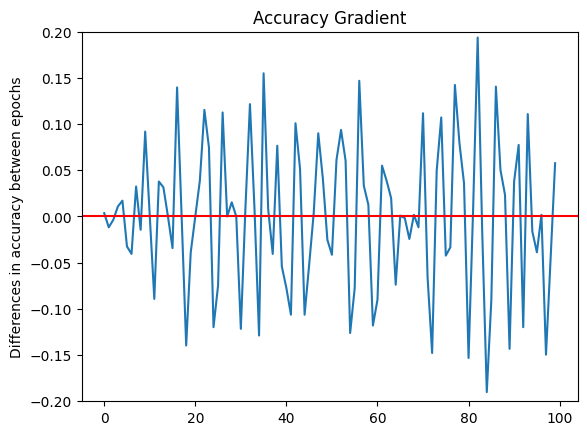

In [37]:
plt.plot(val_acc_diff1)
plt.axhline(y=0,color='r')
plt.title("Accuracy Gradient")
plt.ylabel("Differences in accuracy between epochs")
plt.ylim(-.2,.2)

(-60.0, 60.0)

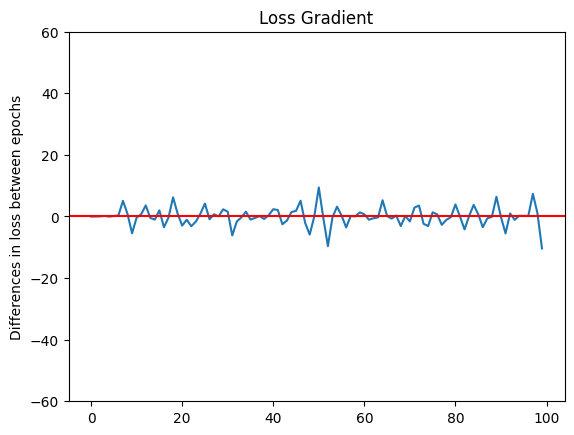

In [38]:
plt.plot(val_loss_diff1)
plt.axhline(y=0,color='r')
plt.title("Loss Gradient")
plt.ylabel("Differences in loss between epochs")
plt.ylim(-60,60)

In [33]:
x = np.arange(25)
# 1st quarter
val_loss1 = val_loss_arr[:25]
val_acc1 = val_acc_arr[:25]
quarter_1 = {
"min_loss": np.min(val_loss1),
"min_acc" : np.min(val_acc1),
"max_loss" : np.max(val_loss1),
"max_acc" : np.max(val_acc1),
"r_loss" : np.corrcoef(x,val_loss1)[0,1],
"r_squared_loss" : np.corrcoef(x,val_loss1)[0,1]**2
}

# 2nd quarter
val_loss2 = val_loss_arr[25:50]
val_acc2 = val_acc_arr[25:50]
quarter_2 = {
"min_loss" : np.min(val_loss2),
"min_acc" : np.min(val_acc2),
"max_loss" : np.max(val_loss2),
"max_acc" : np.max(val_acc2),
"r_loss" : np.corrcoef(x,val_loss2)[0,1],
"r_squared_loss" : np.corrcoef(x,val_loss2)[0,1]**2
}

# 3rd quarter
val_loss3 = val_loss_arr[50:75]
val_acc3 = val_acc_arr[50:75]
quarter_3 = {
"min_loss":np.min(val_loss3),
"min_acc":np.min(val_acc3),
"max_loss" : np.max(val_loss3),
"max_acc" : np.max(val_acc3),
"r_loss" : np.corrcoef(x,val_loss3)[0,1],
"r_squared_loss" : np.corrcoef(x,val_loss3)[0,1]**2
}

# 4th quarter
val_loss4 = val_loss_arr[75:]
val_acc4 = val_acc_arr[75:]
quarter_4 = {
"min_loss" : np.min(val_loss4),
"min_acc" : np.min(val_acc4),
"max_loss" : np.max(val_loss4),
"max_acc" : np.max(val_acc4),
"r_loss" : np.corrcoef(x,val_loss4)[0,1],
"r_squared_loss" : np.corrcoef(x,val_loss4)[0,1]**2
}

In [40]:
quarter_3

{'min_loss': 0.45047616958618164,
 'min_acc': 0.4810810685157776,
 'max_loss': 40.6999397277832,
 'max_acc': 0.8468468189239502,
 'r_loss': 0.0310142102007757,
 'r_squared_loss': 0.0009618812343778994}

In [75]:

x = np.arange(50)
r = np.corrcoef(x,optim.history['val_loss'])[0, 1]

In [76]:
r**2

0.2941255676922358

In [71]:
len(val_loss3)

0

In [39]:
np.std(val_acc_arr[2:24])

0.038080367846676635

In [40]:
np.std(val_loss_arr[2:24])

0.5584143332523406

In [41]:
np.array(val_loss_arr[2:24]).min()

0.7029141187667847

In [18]:
np.array(optim.history['val_accuracy']).max()

0.6360360383987427

In [37]:
x = np.arange(50)
r = np.corrcoef(x,optim.history['val_loss'])[0, 1]

In [49]:
val_acc_diff1 = np.gradient(val_acc_arr)
val_loss_diff1 = np.gradient(val_loss_arr)

val_acc_diff2 = np.gradient(val_acc_diff1)
val_loss_diff2 = np.gradient(val_loss_diff1)

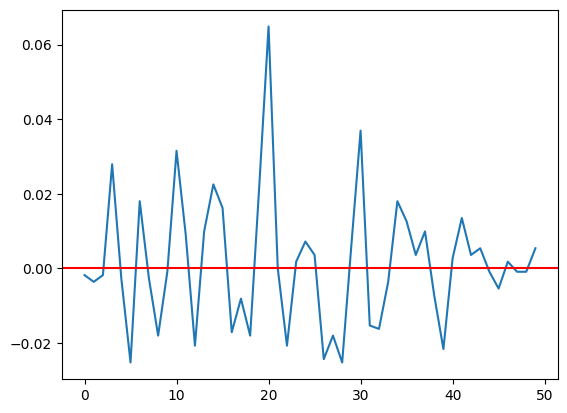

In [59]:
plt.plot(val_acc_diff1)
plt.axhline(y=0,color='r')
#plt.plot(val_acc_diff2)

(-3.0, 3.0)

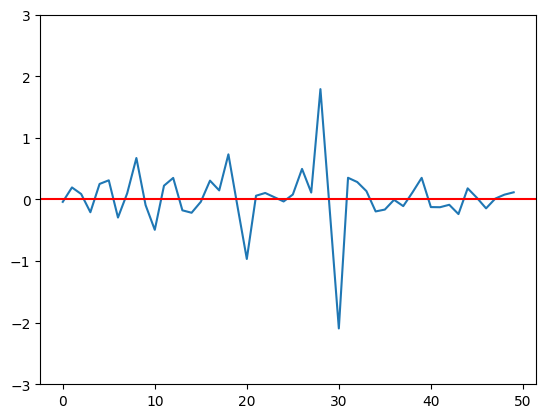

In [64]:
plt.plot(val_loss_diff1)
plt.axhline(y=0,color='r')
plt.ylim(-3,3)

In [ ]:
# maybe the rate of change needs to roughly 

(array([ 1.,  0.,  0.,  2., 14., 77.,  5.,  0.,  0.,  1.]),
 array([-19.6287775 , -15.87430995, -12.11984239,  -8.36537483,
         -4.61090727,  -0.85643971,   2.89802785,   6.65249541,
         10.40696297,  14.16143053,  17.91589808]),
 <BarContainer object of 10 artists>)

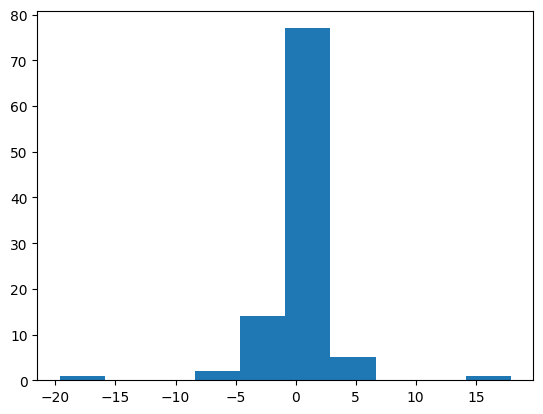

In [90]:
# want to measure the rate of change 
plt.hist(val_loss_diff1)

In [39]:
from tensorflow.keras.models import load_model

best_model = load_model('checkpoint.modelG6.keras')

In [40]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8618 - loss: 0.4500


In [70]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.3992617428302765, Test accuracy: 0.8717579245567322'

In [44]:
# Predict the values from the testing dataset
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)
# compute the confusion matrix
#confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred) 

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Text(0, 0.5, 'freq')

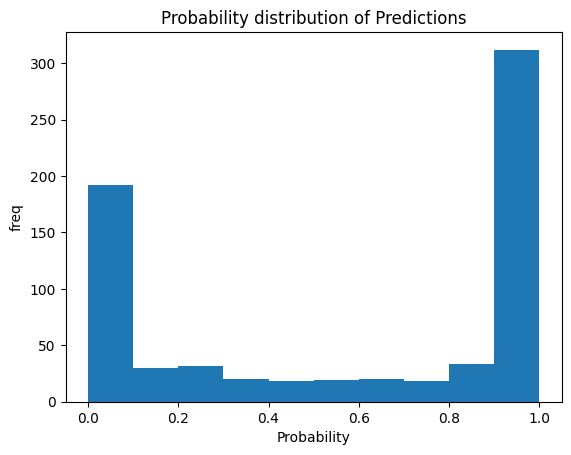

In [41]:
plt.hist(Y_pred_probs.flatten())
plt.title('Probability distribution of Predictions')
plt.xlabel('Probability')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

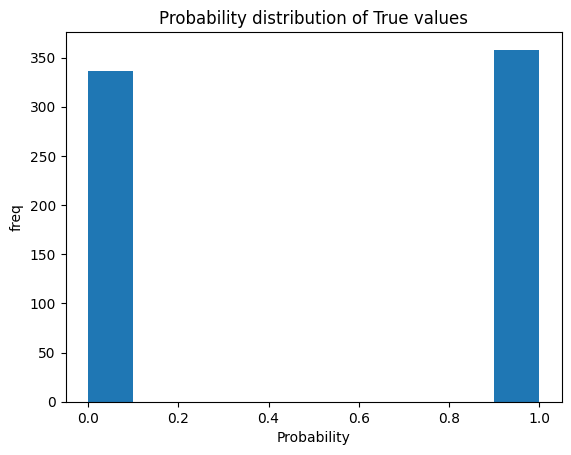

In [73]:
plt.hist(y_test)
plt.title('Probability distribution of True values')
plt.xlabel('Probability')
plt.ylabel('freq')

In [1]:
sum(y_test)

NameError: name 'y_test' is not defined

In [44]:
Y_pred = Y_pred.astype(float).flatten()

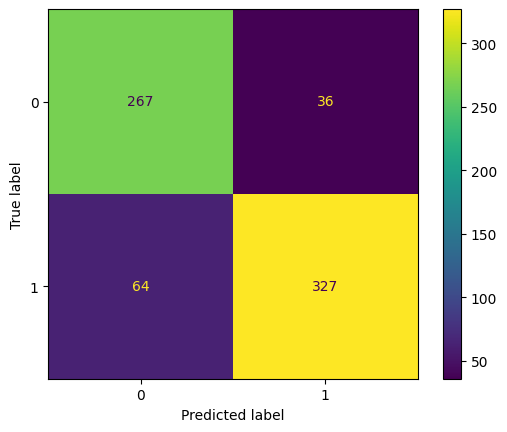

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [43]:
cm

array([[256,  47],
       [ 36, 355]])

In [17]:
TP=152
TN=175
FP=13
FN=1

In [18]:
recall = TP/(TP+FN)
precision = TP/(TP+FP)

print(recall,precision)

0.9934640522875817 0.9212121212121213


In [19]:
(TP+TN)/(TP+TN+FP+FN)

0.9589442815249267